<h4>I used Claude, Anthropic's model to help with the code portion of this assignment.</h4>
<h4>I used Copilot for help understanding these concepts.</h4>

(1) Show that applying the difference-in-differences regression, $y_{it} = \beta_0 + \beta_1 TreatmentGroup_i + \beta_2 PostTreatment_t + \beta_{DiD}(TreatmentGroup_i \times PostTreatment_t) + \epsilon_{it}$ on a sample of just Utah and Colorado, where $y_{it}$ is the crime rate, and treatment is recreational marijuana legalization, will give $\beta_{DiD} = TS^* = CS^*$ from the Treatment Effect lecture. You will need to start by noting things like $\beta_0$ = the average crime rate in Utah before Colorado legalized marijuana, $\beta_0 + \beta_1$
... 
Simulate data associated with this example.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

So I modeled this simulation using these coefficients.

| Coefficient          | Interpretation                                                              |
| -------------------- | --------------------------------------------------------------------------- |
| $\beta_0$            | Average crime rate in **Utah before** Colorado’s legalization               |
| $\beta_1$            | Difference between **Colorado and Utah** before legalization                |
| $\beta_2$            | Change in crime rate in **Utah** from before to after legalization          |
| $\beta_{\text{DiD}}$ | **Additional change** in Colorado after legalization — the treatment effect |

This is what we are proving with this simulation.

$$
\beta_{\text{DID}} = (\overline{y}_{1,\text{after}} - \overline{y}_{1,\text{before}}) - (\overline{y}_{0,\text{after}} - \overline{y}_{0,\text{before}}) = TS^* = CS^*
$$


In [18]:
# Set seed for reproducibility
np.random.seed(1)

# Parameters
n_per_state = 30   # number of observations per state per period
treatment_effect = -2.5  # Suppose legalization reduces crime rate by 2.5 units
baseline_utah = 20
baseline_colorado = 22   # Colorado starts slightly higher
post_increase = 0.5      # General upward trend in both states over time

# Create dataframe structure
data = []
for state, baseline, treated in [("Utah", baseline_utah, 0), ("Colorado", baseline_colorado, 1)]:
    for period, post in [("Before", 0), ("After", 1)]:
        # Expected mean crime rate
        mean = baseline + post * post_increase + treated * post * treatment_effect
        y = np.random.normal(mean, 1, n_per_state)
        for val in y:
            data.append([state, treated, post, val])

df = pd.DataFrame(data, columns=["State", "TreatmentGroup", "PostTreatment", "CrimeRate"])

# Fit the Difference-in-Differences regression
model = smf.ols("CrimeRate ~ TreatmentGroup + PostTreatment + TreatmentGroup:PostTreatment", data=df).fit()

# Display regression summary
# print(model.summary())

# Calculate group means for interpretation
means = df.groupby(["TreatmentGroup", "PostTreatment"])["CrimeRate"].mean().unstack()
print("\nGroup Means (CrimeRate):")
print(means)

# Compute manual Difference-in-Differences
mean_treat_before = means.loc[1, 0]
mean_treat_after = means.loc[1, 1]
mean_control_before = means.loc[0, 0]
mean_control_after = means.loc[0, 1]

TS_star = (mean_treat_after - mean_treat_before) - (mean_control_after - mean_control_before)
print(f"\nManual DiD estimate (TS* or CS*): {TS_star:.3f}")
print(f"Regression β_DiD (interaction term): {model.params['TreatmentGroup:PostTreatment']:.3f}")


Group Means (CrimeRate):
PostTreatment           0          1
TreatmentGroup                      
0               19.940061  20.576568
1               22.163692  19.963121

Manual DiD estimate (TS* or CS*): -2.837
Regression β_DiD (interaction term): -2.837


What this shows is that our regression above matches the manual $DiD$ estimate calculated.

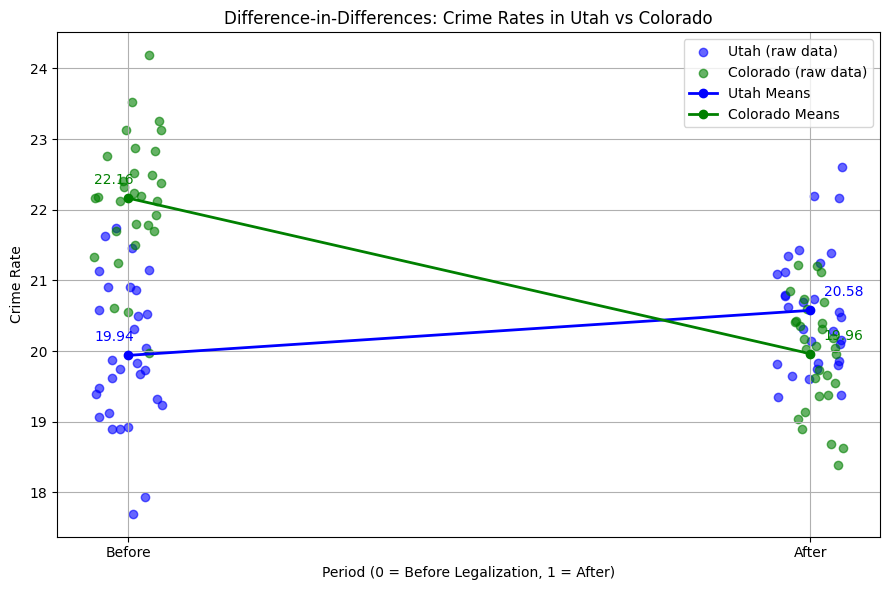

In [19]:
# --- Visualization ---
plt.figure(figsize=(9, 6))

# Jitter for clarity
jitter = np.random.uniform(-0.05, 0.05, len(df))

# Plot raw data points
for state, color in zip(["Utah", "Colorado"], ["blue", "green"]):
    subset = df[df["State"] == state]
    plt.scatter(
        subset["PostTreatment"] + jitter[subset.index],
        subset["CrimeRate"],
        alpha=0.6,
        label=f"{state} (raw data)",
        color=color
    )

# Plot pre/post means for each group
plt.plot([0, 1], [mean_control_before, mean_control_after], 'o-', color='blue', linewidth=2, label='Utah Means')
plt.plot([0, 1], [mean_treat_before, mean_treat_after], 'o-', color='green', linewidth=2, label='Colorado Means')

# Annotate group averages
plt.text(-0.05, mean_control_before+0.2, f"{mean_control_before:.2f}", color='blue')
plt.text(1.02, mean_control_after+0.2, f"{mean_control_after:.2f}", color='blue')
plt.text(-0.05, mean_treat_before+0.2, f"{mean_treat_before:.2f}", color='green')
plt.text(1.02, mean_treat_after+0.2, f"{mean_treat_after:.2f}", color='green')

# Label and formatting
plt.xticks([0, 1], ["Before", "After"])
plt.xlabel("Period (0 = Before Legalization, 1 = After)")
plt.ylabel("Crime Rate")
plt.title("Difference-in-Differences: Crime Rates in Utah vs Colorado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now let's breakdown mathematically why the difference of differences regression is equal to the $TS^*$ and $CS^*$.

We already know that $\hat{TS} = \bar{y}_{1,t>t^*} - \bar{y}_{1,t<t^*}$ and $\hat{CS} = \bar{y}_{1,t>t^*} -  \bar{y}_{0,t>t^*}$
So then let’s show the $TS_{treated}$ & $CS_{treated}$.
We can re-use the equations in the lecture.

$$
TS_{treated} = \bar{y}_{1,t>t^*} - \bar{y}_{1,t<t^*} - \left[\bar{y}_{0,t>t^*} - \bar{y}_{0,t<t^*}\right]
$$
,
$$
CS_{treated} = \bar{y}_{1,t>t^*} -  \bar{y}_{0,t>t^*} - \left[\bar{y}_{1,t<t^*} -  \bar{y}_{0,t<t^*} \right]
$$

Now let's put this in terms of our $\beta_0$, $\beta_1$, $\beta_2$, $\beta_{DiD}$ to show why they're equivalent.

$$
TS_{\text{treated}} = (\bar{y}_{\text{treated,after}} - \bar{y}_{\text{treated,before}}) = ((\beta_0 + \beta_1 + \beta_{\text{DID}}) - (\beta_0 + \beta_1)) = \beta_{\text{DID}}
$$
$$
TS_{\text{control}} = (\bar{y}_{\text{control,after}} - \bar{y}_{\text{control,before}}) = ((\beta_0 + \beta_2) - \beta_0) = \beta_2
$$
$$
TS^* = TS_{\text{treated}} - TS_{\text{control}} = (\beta_2 + \beta_{\text{DID}}) - \beta_2 = \beta_{\text{DID}}
$$
,
$$
CS_{\text{before}} = (\bar{y}_{\text{treated,before}} - \bar{y}_{\text{control,before}}) = ((\beta_0 + \beta_1) - \beta_0) = \beta_1
$$
$$
CS_{\text{after}} = (\bar{y}_{\text{treated,after}} - \bar{y}_{\text{control,after}}) = ((\beta_0 + \beta_1 + \beta_{\text{DID}}) - (\beta_0 + \beta_2)) = \beta_1 + \beta_{\text{DID}} - \beta_2
$$
$$
CS^* = CS_{\text{after}} - CS_{\text{before}} = (\beta_1 + \beta_{\text{DID}} - \beta_2) - \beta_1 = \beta_{\text{DID}}
$$

Now we can finally say and prove $\beta_{DiD} = TS^* = CS^*$ because derivations give us the same results.

(2) Simulate or collect data that may suffer from an endogeneity issue. Explain the endogeneity issue. Compare the outcomes of a 2SLS model a Two-Stage Machine Learning model and discuss the similarities and differences. If there are no differences, explain why that is.

Endogeneity occurs when any independent variable is correlated with the error term in regression. An important note is that the independent doesn't directly affect the error term, rather it is correlated. This correlation comes from a couple of things, namely omitted variables, simultaneity bias, and/or measurement error.

Let's go over some of the ways endogeneity shows up in models.
Omitted variables are independent variables that may have had influence on the outcome of the model's performance. Since this independent variable did have some influence on the target then the error term eats this difference which correlates the error term to the independent variable indirectly.

Call back to week 1 with supply and demand we learned of simultaneity that is present in certain relationships. Basically, our target(y) and predictors(X) are intertwined in a way that they both influence each other. This back and forth creates a feedback loop which violates OLS's assumption that X is independent of our error term which leads to endogeneity.

So, the common thing to notice in endogeneity is that it violates our OLS key assumptions which is that our independent variables must not be correlated with our error term.

In [20]:
# Simulate data
np.random.seed(2)
n = 1000

Z = np.random.normal(size=n)                  # Instrument
U = np.random.normal(size=n)                  # Error term
X = 0.8 * Z + 0.5 * U                        # Endogenous regressor
Y = 2 * X + U + np.random.normal(size=n)      # Outcome

df = pd.DataFrame({'Y': Y, 'X': X, 'Z': Z})

ols_model = sm.OLS(df['Y'], sm.add_constant(df['X'])).fit()
print("\n--- OLS Results ---")
print(ols_model.summary().tables[1])

iv_model = IV2SLS.from_formula('Y ~ 1 + [X ~ Z]', data=df).fit()
print("\n--- 2SLS Results ---")
print(iv_model.summary.tables[1])

train, test = train_test_split(df, test_size=0.3, random_state=42)

# Stage 1: Predict X from Z
rf_stage1 = RandomForestRegressor(random_state=42)
rf_stage1.fit(train[['Z']], train['X'])
train['X_hat'] = rf_stage1.predict(train[['Z']])
test['X_hat'] = rf_stage1.predict(test[['Z']])

# Stage 2: Predict Y from predicted X_hat
rf_stage2 = RandomForestRegressor(random_state=42)
rf_stage2.fit(train[['X_hat']], train['Y'])
y_pred = rf_stage2.predict(test[['X_hat']])

print("\n--- Random Forest Two-Stage ---")
print(f"R² (on test): {r2_score(test['Y'], y_pred):.3f}")



--- OLS Results ---
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0296      0.043      0.689      0.491      -0.055       0.114
X              2.5377      0.046     55.304      0.000       2.448       2.628

--- 2SLS Results ---
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0045     0.0461     0.0980     0.9220     -0.0859      0.0950
X              1.9633     0.0575     34.163     0.0000      1.8507      2.0759

--- Random Forest Two-Stage ---
R² (on test): -0.005


c:\Users\n0308g\python_venv\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


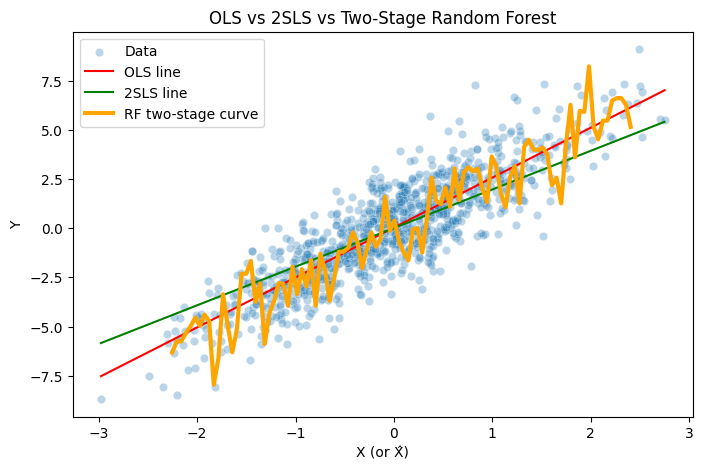

In [21]:
# Generate x-grid over observed range
x_grid = np.linspace(df['X'].min(), df['X'].max(), 100)
x_grid_df = pd.DataFrame({'X': x_grid})

# Create a grid of X_hat values over observed range
x_grid = np.linspace(test['X_hat'].min(), test['X_hat'].max(), 100).reshape(-1, 1)

# Predict Y using stage-2 Random Forest
y_grid_pred = rf_stage2.predict(x_grid)

# OLS fitted line
ols_line = ols_model.predict(sm.add_constant(x_grid_df))

# 2SLS fitted line
params = iv_model.params

# Handle intercept name flexibly
intercept_name = 'Intercept' if 'Intercept' in params.index else 'const'
iv_intercept = params.get(intercept_name, 0)
iv_slope = params['X']
iv_line = iv_intercept + iv_slope * x_grid_df['X']

# Plot everything together
plt.figure(figsize=(8,5))
sns.scatterplot(x='X', y='Y', data=df, alpha=0.3, label='Data')
plt.plot(x_grid_df['X'], ols_line, color='red', label='OLS line')
plt.plot(x_grid_df['X'], iv_line, color='green', label='2SLS line')
plt.plot(x_grid, y_grid_pred, color='orange', linewidth=3, label='RF two-stage curve')
plt.xlabel("X (or X̂)")
plt.ylabel("Y")
plt.title("OLS vs 2SLS vs Two-Stage Random Forest")
plt.legend()
plt.show()


Okay. Let's breakdown some of the similarities and differences found in the 3 models above.

Firstly, I wanted to show a naive OLS line with bias since it helps show that the 2SLS regression model corrects for the bias we purposely put into our data. We can see that the biased line has a different coefficient and has a steeper slope. 

The interesting part is our chosen random forest model implemented into a two-stage setup similarly to 2SLS. Simply put, the first stage learned the X points from the Z instrument we set earlier and then stage 2 predicted the Y values from the predicted X values. This was done in an effort to capture how our y would respond to an instrument X. 

Random forest and linear regression function in different ways because linear regression is causal, and we can explain it with an equation. A random forest is a bunch of small decision trees that are trying to predict the next best point, so this sort of a technique can be used to predict non-linear trends as well.

So, RF 2SLS tried to predict what y-values were next from the predicted X values from the given Z instrument. 
This differs from the equation that 2SLS may follow since it has a causal effect we can look at.

The main similarities between 2SLS with linear regression and 2SLS with a random forest is that they both use two stages. However, they obtain predictions in very different ways as mentioned above, and both methods have their time and place for use in machine learning and econometrics.
